In [37]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Fill in NaN and getting overview of data

In [38]:
df = pd.read_csv('streamlit_app/stroke.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [39]:
df = df[df['gender']!='Other']

In [40]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [41]:
df.value_counts('gender')

gender
Female    2994
Male      2115
Name: count, dtype: int64

#### Here we see that smoking_status has a lot of rows with Unknown, for the purpose of simplicity I will treat Unknown as a category on its own when it's being one hot encoded

In [42]:
df.value_counts('smoking_status')

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

In [43]:
df.drop('id',axis=1,inplace=True)

# Splitting the data

In [44]:
X = df.drop('stroke', axis = 1)
y = df.stroke

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Filling in missing values with mean of BMI feature

In [45]:
X_train['bmi'].fillna(X_train['bmi'].mean(),inplace=True)
X_test['bmi'].fillna(X_test['bmi'].mean(),inplace=True)

In [46]:
X_test.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

# Pipeline creation - Preprocessing

In [47]:
column_trans = make_column_transformer(
    (OneHotEncoder(),['work_type','smoking_status']),
    (OrdinalEncoder(),['gender','ever_married','Residence_type']),
    (StandardScaler(), ['age','avg_glucose_level','bmi']),
    remainder='passthrough')

In [48]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
smote = SMOTE()

In [49]:
logreg = LogisticRegression(class_weight='balanced')
# pipe = make_pipeline(column_trans, smote, logreg)
pipe = ImbPipeline(steps=[('preprocessor', column_trans), 
                               ('smote', smote), 
                               ('classifier', logreg)])

In [50]:
svm = SVC(class_weight='balanced',probability=True)
pipe_svm = ImbPipeline(steps=[('preprocessor', column_trans), 
                               ('smote', smote), 
                               ('classifier', svm)])

In [51]:
rfc = RandomForestClassifier(class_weight='balanced')
pipe_rfc = ImbPipeline(steps=[('preprocessor', column_trans), 
                               ('smote', smote), 
                               ('classifier', rfc)])

## Logistic Regression MODEL

In [52]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Evaluation Metrics for Logistic Regression")
print("Accuracy:", accuracy_score(y_test,y_pred))
print("F1:", f1_score(y_test,y_pred))
print("Recall:", recall_score(y_test,y_pred))
print("Precision:", precision_score(y_test,y_pred))

Evaluation Metrics for Logistic Regression
Accuracy: 0.7416829745596869
F1: 0.27472527472527475
Recall: 0.8064516129032258
Precision: 0.16556291390728478


### With hyperparameter tuning for Logistic Regression

In [54]:
param_grid_log_reg = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],  # 'l1' requires solver='liblinear'
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [3000]
}

# Initialize GridSearchCV
grid_search_log_reg = GridSearchCV(pipe, param_grid_log_reg, scoring='f1', cv=5)

# Fit GridSearchCV
grid_search_log_reg.fit(X_train, y_train)
best_pipe_log = grid_search_log_reg.best_estimator_

best_pipe_log.fit(X_train, y_train)
y_pred = best_pipe_log.predict(X_test)

print("Evaluation Metrics for Logistic Regression with hyperparameter tuning")
print("Accuracy:", accuracy_score(y_test,y_pred))
print("F1:", f1_score(y_test,y_pred))
print("Recall:", recall_score(y_test,y_pred))
print("Precision:", precision_score(y_test,y_pred))

Evaluation Metrics for Logistic Regression with hyperparameter tuning
Accuracy: 0.7416829745596869
F1: 0.2707182320441989
Recall: 0.7903225806451613
Precision: 0.16333333333333333


## SVC MODEL

In [55]:
pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)

print("Evaluation Metrics for SVC")
print("Accuracy:", accuracy_score(y_test,y_pred))
print("F1:", f1_score(y_test,y_pred))
print("Recall:", recall_score(y_test,y_pred))
print("Precision:", precision_score(y_test,y_pred))

Evaluation Metrics for SVC
Accuracy: 0.8189823874755382
F1: 0.2570281124497992
Recall: 0.5161290322580645
Precision: 0.1711229946524064


### With hyperparameter tuning for SVC

In [56]:
param_grid_svc = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto']  # Only relevant for 'rbf', 'poly', and 'sigmoid' kernels
}

# Initialize GridSearchCV
grid_search_svc = GridSearchCV(pipe_svm, param_grid_svc, scoring='f1', cv=5)

# Fit GridSearchCV
grid_search_svc.fit(X_train, y_train)
best_pipe_svc = grid_search_svc.best_estimator_

print("Evaluation Metrics for SVC with hyperparameter tuning")
print("Accuracy:", accuracy_score(y_test,y_pred))
print("F1:", f1_score(y_test,y_pred))
print("Recall:", recall_score(y_test,y_pred))
print("Precision:", precision_score(y_test,y_pred))

Evaluation Metrics for SVC with hyperparameter tuning
Accuracy: 0.8189823874755382
F1: 0.2570281124497992
Recall: 0.5161290322580645
Precision: 0.1711229946524064


## RFC MODEL

In [57]:
pipe_rfc.fit(X_train, y_train)
y_pred = pipe_rfc.predict(X_test)

print("Evaluation Metrics for RFC")
print("Accuracy:", accuracy_score(y_test,y_pred))
print("F1:", f1_score(y_test,y_pred,average='weighted'))
print("Recall:", recall_score(y_test,y_pred,average='weighted'))
print("Precision:", precision_score(y_test,y_pred,average='weighted'))

Evaluation Metrics for RFC
Accuracy: 0.923679060665362
F1: 0.9110314352945115
Recall: 0.923679060665362
Precision: 0.9014098436546515


### With hyperparameter tuning for RFC

In [58]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe_rfc, param_grid, scoring='f1', cv=5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)
best_pipe_rfc = grid_search.best_estimator_

best_pipe_rfc.fit(X_train, y_train)
y_pred = best_pipe_rfc.predict(X_test)

print("Evaluation Metrics for RFC with hyperparameter tuning")
print("Accuracy:", accuracy_score(y_test,y_pred))
print("F1:", f1_score(y_test,y_pred,average='weighted'))
print("Recall:", recall_score(y_test,y_pred,average='weighted'))
print("Precision:", precision_score(y_test,y_pred,average='weighted'))

Evaluation Metrics for RFC with hyperparameter tuning
Accuracy: 0.8571428571428571
F1: 0.8794121225393581
Recall: 0.8571428571428571
Precision: 0.9077331016299137


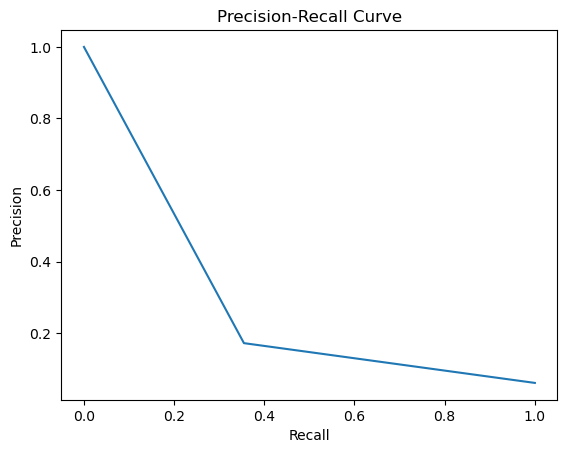

In [60]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [61]:
from sklearn.metrics import confusion_matrix

y_pred = pipe_rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[937  23]
 [ 55   7]]


AUC-ROC: 0.76


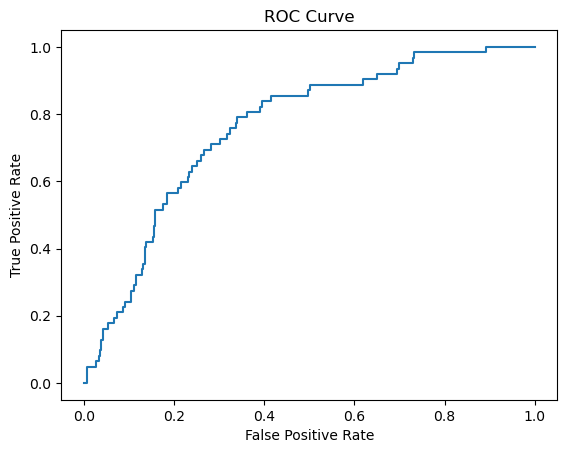

In [62]:
from sklearn.metrics import roc_auc_score, roc_curve


y_pred_proba = pipe_svm.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [63]:
import numpy as np
print("Test class distribution:", dict(zip(*np.unique(y_test, return_counts=True))))
print("Predicted class distribution:", dict(zip(*np.unique(y_pred, return_counts=True))))

Test class distribution: {0: 960, 1: 62}
Predicted class distribution: {0: 992, 1: 30}


In [64]:
y_prob = best_pipe_rfc.predict_proba(X_test)
positive_prob = y_prob[:,1]
print(X_test[:5],positive_prob[:5]*100)

      gender   age  hypertension  heart_disease ever_married      work_type  \
4688    Male  31.0             0              0           No  Self-employed   
4478    Male  40.0             0              0          Yes  Self-employed   
3521    Male  52.0             0              0          Yes        Private   
4355  Female  79.0             1              0          Yes  Self-employed   
3826  Female  75.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level   bmi smoking_status  
4688          Rural              64.85  23.0        Unknown  
4478          Rural              65.29  28.3   never smoked  
3521          Rural             111.04  30.0   never smoked  
4355          Rural              76.64  19.5   never smoked  
3826          Rural              94.77  27.2   never smoked   [ 1.70012543  6.93348071 24.61330464 45.56446429 46.96187218]


#### Save the model to use in the Streamlit app

In [65]:
import joblib

joblib.dump(best_pipe_rfc,'best_pipe_rfc.pkl')

['best_pipe_rfc.pkl']